In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import progressbar as progressbar
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
print(f'TF version: {tf.__version__}')
tf.config.list_physical_devices()

TF version: 2.1.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Read Data

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '../datasets/'

## Amazon Fashion

In [4]:
# data_path = 'data/Amazon/'
# file_name = 'Amazon_full' # file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'
# file_name = 'am_80k_users'
# file_name = 'am_40k_users'
file_name = 'am_like_ml'

## MovieLens

In [5]:
# data_path = 'data/ML/'
file_name = 'ml_1m'
# file_name = 'ML_full' # file_name = 'ML_05_users'
# file_name = 'ML_01_users'

In [6]:
test_set_cfrnn = pd.read_pickle(path + 'test_set_ml_cfrnn')
val_set_cfrnn = pd.read_pickle(path +  'val_set_ml_cfrnn')
train_set_cfrnn = pd.read_pickle(path + 'train_set_ml_cfrnn')

from Data_prep import leave_last_x_out_2

add_to_train, val_set = leave_last_x_out_2(val_set_cfrnn)
add_to_train_2, test_set = leave_last_x_out_2(test_set_cfrnn)

train_set = pd.concat([train_set_cfrnn, add_to_train, add_to_train_2])

In [7]:
df = pd.read_pickle(path + file_name)
df.user_id = df.user_id.astype('category').cat.codes
df.item_id = df.item_id.astype('category').cat.codes
df.head()

,rating,datetime,user_id,item_id
0,4,2000-12-31 22:00:19,0,2969
1,4,2000-12-31 22:00:55,0,1574
2,5,2000-12-31 22:00:55,0,957
3,5,2000-12-31 22:00:55,0,1178
4,3,2000-12-31 22:01:43,0,2147


### Read ML split (paper)

In [56]:
test_set = pd.read_pickle(path + 'ml_1m_test')
train_set = pd.read_pickle(path + 'ml_1m_train')

### Read am_like_ml splits

In [30]:
test_set = pd.read_pickle(path + 'test_set_am_like_ml')
val_set = pd.read_pickle(path + 'val_set_am_like_ml')
train_set = pd.read_pickle(path + 'train_set_am_like_ml')

### Subset data

In [ ]:
from Data_prep import leave_users_out
remaining, subset = leave_users_out(df, 60000)
print(len(subset))
df = subset
df.user_id = df.user_id.astype('category').cat.codes
df.item_id = df.item_id.astype('category').cat.codes

---
# Data Prep

## Dataset Params

In [8]:
val_perc = test_perc = 0.1
n_last_items_val = n_last_items_test = 1

total_items = len(df.item_id.unique())
total_users = len(df.user_id.unique())
print(f'total_items: {total_items}')
print(f'total_users: {total_users}')

total_items: 3706
total_users: 6040


## Create Split

In [8]:
from Data_prep import train_val_test_split
datasets = train_val_test_split(df, val_perc, test_perc, n_last_items_val, n_last_items_test)
train_set, val_set, test_set = datasets

In [9]:
len(test_set.user_id.unique())

4000

---
# Neural Collaborative Filtering (NCF)
Using the NCF framework we build Generalized Matrix Factorisation (GMF), Multiplayer Perceptron Matrix Factorisation (MLP) and combine the two in Neural Matrix Factorisation (NeuMF)
- paper: http://papers.www2017.com.au.s3-website-ap-southeast-2.amazonaws.com/proceedings/p173.pdf
- blog: https://medium.com/@victorkohler/collaborative-filtering-using-deep-neural-networks-in-tensorflow-96e5d41a39a1
- code: https://github.com/Leavingseason/NeuralCF/blob/master

## Set Parameters

In [17]:
store_path = '../NeuMF_storage/GS/'
gs_result_name = f'GS_NeuMF_bs_{256}'
gs_res = pd.read_pickle(store_path + gs_result_name).sort_values('test_rec@10', ascending=False)

In [20]:
gs_res.iloc[0]

test_rec@10                                                        0.01925
100_sample_val_rec@10                                                 0.19
val_metrics              [[rank_at, hitcounts, recall, precision, ndcg]...
test_metrics                rank_at  hitcounts   recall  precision     ...
loss                     [0.46384, 0.35846, 0.325, 0.30419, 0.28889, 0....
train_time                                                         1294.88
learning_rate                                                       0.0001
batch_size                                                             256
layers                                                     [16, 32, 16, 8]
reg_layers                                    [1e-06, 1e-06, 1e-06, 1e-06]
reg_mf                                                              [0, 0]
nolf                                                                     8
epochs                                                                  14
sample_size              

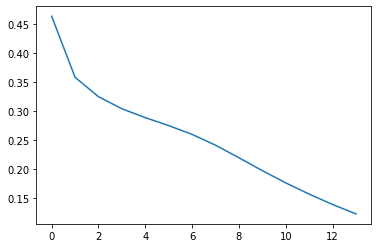

In [18]:
plt.plot(gs_res.iloc[0]['loss'])

In [9]:
# run_num = 'am_40k_nolf_8'
# run_num = 'am_like_ml_nolf_8'
# run_num = 'ml_1m_nolf_8'
run_num = 'ml_1m_nolf_8_cfrnn_data'

In [10]:
GMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'nolf': 8,
    'regs': [0,0],
    'epochs': 10,
    'sample_size': len(train_set),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'ckpt_dir': f'../NeuMF_storage/GMF_ckpts_{run_num}/ckpts',
    'optimizer':'Adam'
}

In [11]:
MLP_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0,0,0,0],   #ML: [+-0.0005,0,0,0],
    'epochs': 10,
    'sample_size': len(train_set),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 10,
    'ckpt_dir': f'../NeuMF_storage/MLP_ckpts_{run_num}/ckpts',
    'optimizer':'Adam'
}

In [12]:
NeuMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0,0,0,0],#[0.0001, 0.0001, 0.0001, 0.0001],
    'reg_mf': [0,0],
    'nolf': 8,
    'epochs': 20,
    'sample_size': len(train_set),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'ckpt_dir': f'../NeuMF_storage/NeuMF_ckpts_{run_num}/ckpts',
    'optimizer':'Adam'
}


## Init

In [13]:
from NCF import NCF
NCF = NCF(total_users, total_items, GMF_params, MLP_params, NeuMF_params)

NCF.build_GMF_model()
NCF.build_MLP_model()
NCF.build_NeuMF_model()

## Training

### Read Stored Samples (3min for ML_1m)

In [16]:
sample_path = '../NeuMF_storage/samples_ml_1m_cfrnn_4_neg/'
sample_name = 'ml_1m_sample_'

# sample_path = '../NeuMF_storage/samples_ml_1m_4_neg/'
# sample_name = 'ml_1m_sample_'

# sample_path = '../NeuMF_storage/samples_am_40k_4_neg/'
# sample_path = '../NeuMF_storage/samples_am_40k_8_neg/'
# sample_name = 'am_40k_sample_'

# sample_path = '../NeuMF_storage/samples_am_like_ml_4_neg/'
# sample_name = 'am_40k_sample_'

In [17]:
%%time
import csv
samples = []
pbar = progressbar.ProgressBar()
for sample_num in pbar(range(20)):
    with open(f'{sample_path}{sample_name}{sample_num}.csv', 'r') as read_obj:
        sample = [[], [], []]
        csv_reader = csv.reader(read_obj)
        sample_str = list(csv_reader)
        
        for user_input, item_input, label in zip(sample_str[0], sample_str[1], sample_str[2]):
            sample[0].append(int(user_input))
            sample[1].append(int(item_input))
            sample[2].append(int(label))
        
    samples.append(sample)

CPU times: user 2min 3s, sys: 11.9 s, total: 2min 15s
Wall time: 2min 25s


# Fit model

## GMF 4 neg samples

In [18]:
GMF_val_metrics = NCF.train_model('GMF', samples, train_set, val_set, store_path=f'../weights/GMF_weights_{run_num}/GMF_weights') 


Fitting GMF with parameters:
learning_rate                                               0.0005
batch_size                                                     256
nolf                                                             8
regs                                                        [0, 0]
epochs                                                          10
sample_size                                                 998709
num_neg                                                          4
ckpt_dir         ../NeuMF_storage/GMF_ckpts_ml_1m_nolf_8_cfrnn_...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 4993545 samples
4993545/4993545 [==============================] - 84s 17us/sample - loss: 0.3817


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006     0.0060  0.006000
1        5          4   0.008     0.0016  0.007262
2       10          6   0.012     0.0012  0.008466
3       15          9   0.018     0.0012  0.009990
4       20         16   0.032     0.0016  0.013265]
Epoch: 1
Train on 4993545 samples
4993545/4993545 [==============================] - 84s 17us/sample - loss: 0.3452


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006   0.006000  0.006000
1        5          4   0.008   0.001600  0.007000
2       10          8   0.016   0.001600  0.009552
3       15         11   0.022   0.001467  0.011052
4       20         15   0.030   0.001500  0.012921]
Epoch: 2
Train on 4993545 samples
4993545/4993545 [==============================] - 83s 17us/sample - loss: 0.3174


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          5   0.010   0.002000  0.006409
2       10         12   0.024   0.002400  0.010988
3       15         17   0.034   0.002267  0.013639
4       20         25   0.050   0.002500  0.017410]
Epoch: 3
Train on 4993545 samples
4993545/4993545 [==============================] - 83s 17us/sample - loss: 0.2987


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          7   0.014   0.002800  0.008861
2       10         10   0.020   0.002000  0.010778
3       15         16   0.032   0.002133  0.013967
4       20         24   0.048   0.002400  0.017729]
Epoch: 4
Train on 4993545 samples
4993545/4993545 [==============================] - 83s 17us/sample - loss: 0.2842


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002     0.0020  0.002000
1        5          7   0.014     0.0028  0.009047
2       10          9   0.018     0.0018  0.010292
3       15         15   0.030     0.0020  0.013513
4       20         27   0.054     0.0027  0.019239]
Epoch: 5
Train on 4993545 samples
4993545/4993545 [==============================] - 83s 17us/sample - loss: 0.2755


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          0   0.000     0.0000  0.000000
1        5          7   0.014     0.0028  0.008083
2       10         14   0.028     0.0028  0.012343
3       15         18   0.036     0.0024  0.014450
4       20         22   0.044     0.0022  0.016313]
Epoch: 6
Train on 4993545 samples
4993545/4993545 [==============================] - 83s 17us/sample - loss: 0.2708


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          0   0.000   0.000000  0.000000
1        5          8   0.016   0.003200  0.008194
2       10         12   0.024   0.002400  0.010842
3       15         17   0.034   0.002267  0.013491
4       20         20   0.040   0.002000  0.014915]
Epoch: 7
Train on 4993545 samples
4993545/4993545 [==============================] - 82s 17us/sample - loss: 0.2681


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          8   0.016   0.003200  0.008932
2       10         15   0.030   0.003000  0.013427
3       15         17   0.034   0.002267  0.014464
4       20         22   0.044   0.002200  0.016814]
Epoch: 8
Train on 4993545 samples
4993545/4993545 [==============================] - 83s 17us/sample - loss: 0.2664


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          7   0.014   0.002800  0.009821
2       10         16   0.032   0.003200  0.015613
3       15         20   0.040   0.002667  0.017703
4       20         25   0.050   0.002500  0.020034]
Epoch: 9
Train on 4993545 samples
4993545/4993545 [==============================] - 82s 17us/sample - loss: 0.2652


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5         10   0.020   0.004000  0.011167
2       10         18   0.036   0.003600  0.016214
3       15         23   0.046   0.003067  0.018836
4       20         30   0.060   0.003000  0.022173]


## MLP 4 neg samples

In [19]:
MLP_val_metrics = NCF.train_model('MLP', samples, train_set, val_set, store_path=f'../weights/MLP_weights_{run_num}/MLP_weights') 


Fitting MLP with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                                            [0, 0, 0, 0]
epochs                                                          10
sample_size                                                 998709
num_neg                                                         10
ckpt_dir         ../NeuMF_storage/MLP_ckpts_ml_1m_nolf_8_cfrnn_...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 4993545 samples
4993545/4993545 [==============================] - 94s 19us/sample - loss: 0.3518


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          5   0.010   0.002000  0.006159
2       10         12   0.024   0.002400  0.010692
3       15         16   0.032   0.002133  0.012813
4       20         19   0.038   0.001900  0.014234]
Epoch: 1
Train on 4993545 samples
4993545/4993545 [==============================] - 93s 19us/sample - loss: 0.3175


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          7   0.014   0.002800  0.007897
2       10         11   0.022   0.002200  0.010545
3       15         16   0.032   0.002133  0.013155
4       20         21   0.042   0.002100  0.015545]
Epoch: 2
Train on 4993545 samples
4993545/4993545 [==============================] - 94s 19us/sample - loss: 0.3025


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002     0.0020  0.002000
1        5          4   0.008     0.0016  0.004547
2       10          8   0.016     0.0016  0.007001
3       15         12   0.024     0.0016  0.009137
4       20         18   0.036     0.0018  0.011941]
Epoch: 3
Train on 4993545 samples
4993545/4993545 [==============================] - 93s 19us/sample - loss: 0.2906


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          5   0.010   0.002000  0.006635
2       10          7   0.014   0.001400  0.007978
3       15         13   0.026   0.001733  0.011113
4       20         22   0.044   0.002200  0.015338]
Epoch: 4
Train on 4993545 samples
4993545/4993545 [==============================] - 94s 19us/sample - loss: 0.2842


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          7   0.014   0.002800  0.009159
2       10         11   0.022   0.002200  0.011807
3       15         17   0.034   0.002267  0.014980
4       20         24   0.048   0.002400  0.018273]
Epoch: 5
Train on 4993545 samples
4993545/4993545 [==============================] - 94s 19us/sample - loss: 0.2799


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006   0.006000  0.006000
1        5          5   0.010   0.002000  0.007861
2       10          8   0.016   0.001600  0.009596
3       15         11   0.022   0.001467  0.011148
4       20         21   0.042   0.002100  0.015947]
Epoch: 6
Train on 4993545 samples
4993545/4993545 [==============================] - 93s 19us/sample - loss: 0.2766


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          4   0.008   0.001600  0.005861
2       10          9   0.018   0.001800  0.008970
3       15         13   0.026   0.001733  0.011079
4       20         21   0.042   0.002100  0.014809]
Epoch: 7
Train on 4993545 samples
4993545/4993545 [==============================] - 94s 19us/sample - loss: 0.2742


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          4   0.008   0.001600  0.005861
2       10          9   0.018   0.001800  0.009133
3       15         11   0.022   0.001467  0.010158
4       20         17   0.034   0.001700  0.012988]
Epoch: 8
Train on 4993545 samples
4993545/4993545 [==============================] - 93s 19us/sample - loss: 0.2722


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004     0.0040  0.004000
1        5          4   0.008     0.0016  0.005774
2       10         10   0.020     0.0020  0.009542
3       15         18   0.036     0.0024  0.013859
4       20         25   0.050     0.0025  0.017151]
Epoch: 9
Train on 4993545 samples
4993545/4993545 [==============================] - 94s 19us/sample - loss: 0.2706


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          5   0.010   0.002000  0.006897
2       10          9   0.018   0.001800  0.009404
3       15         14   0.028   0.001867  0.012051
4       20         23   0.046   0.002300  0.016293]


## NeuMF 4 neg samples

#### Load weights for NeuMF

In [20]:
NCF.use_pretrain_model(GMF_weights_path=f'../weights/GMF_weights_{run_num}/GMF_weights',
                       MLP_weights_path=f'../weights/MLP_weights_{run_num}/MLP_weights')
NCF.NeuMF_params['optimizer'] = 'SGD'

In [21]:
%%time
NeuMF_val_metrics = NCF.train_model('NeuMF', samples, train_set, val_set, store_path=f'../weights/NeuMF_weights_{run_num}/NeuMF_weights', verbose=1) 


Fitting NeuMF with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                                            [0, 0, 0, 0]
reg_mf                                                      [0, 0]
nolf                                                             8
epochs                                                          20
sample_size                                                 998709
num_neg                                                          4
ckpt_dir         ../NeuMF_storage/NeuMF_ckpts_ml_1m_nolf_8_cfrn...
optimizer                                                      SGD
Name: 0, dtype: object
Epoch: 0
Train on 4993545 samples
4993545/4993545 [==============================] - 107s 21us/sample - loss: 0.2570


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          5   0.010   0.002000  0.005321
2       10         12   0.024   0.002400  0.009895
3       15         17   0.034   0.002267  0.012489
4       20         29   0.058   0.002900  0.018114]
Epoch: 1
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2519


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          5   0.010   0.002000  0.006159
2       10         12   0.024   0.002400  0.010481
3       15         19   0.038   0.002533  0.014081
4       20         24   0.048   0.002400  0.016457]
Epoch: 2
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2482


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          6   0.012   0.002400  0.007508
2       10         11   0.022   0.002200  0.010658
3       15         20   0.040   0.002667  0.015483
4       20         27   0.054   0.002700  0.018790]
Epoch: 3
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2453


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          6   0.012   0.002400  0.007159
2       10         12   0.024   0.002400  0.010973
3       15         19   0.038   0.002533  0.014628
4       20         26   0.052   0.002600  0.017946]
Epoch: 4
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2431


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          6   0.012   0.002400  0.006846
2       10         12   0.024   0.002400  0.010545
3       15         17   0.034   0.002267  0.013069
4       20         22   0.044   0.002200  0.015443]
Epoch: 5
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2412


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002     0.0020  0.002000
1        5          7   0.014     0.0028  0.007985
2       10         10   0.020     0.0020  0.009767
3       15         21   0.042     0.0028  0.015455
4       20         27   0.054     0.0027  0.018309]
Epoch: 6
Train on 4993545 samples
4993545/4993545 [==============================] - 105s 21us/sample - loss: 0.2396


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          5   0.010   0.002000  0.005846
2       10         12   0.024   0.002400  0.010247
3       15         20   0.040   0.002667  0.014435
4       20         27   0.054   0.002700  0.017735]
Epoch: 7
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2383


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002   0.002000  0.002000
1        5          6   0.012   0.002400  0.006774
2       10         11   0.022   0.002200  0.009846
3       15         19   0.038   0.002533  0.014056
4       20         28   0.056   0.002800  0.018284]
Epoch: 8
Train on 4993545 samples
4993545/4993545 [==============================] - 105s 21us/sample - loss: 0.2372


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          7   0.014   0.002800  0.008671
2       10         14   0.028   0.002800  0.012818
3       15         17   0.034   0.002267  0.014428
4       20         29   0.058   0.002900  0.020085]
Epoch: 9
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2363


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          1   0.002     0.0020  0.002000
1        5          4   0.008     0.0016  0.005123
2       10         13   0.026     0.0026  0.010919
3       15         21   0.042     0.0028  0.015175
4       20         31   0.062     0.0031  0.019907]
Epoch: 10
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2355


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          8   0.016   0.003200  0.009270
2       10         12   0.024   0.002400  0.011772
3       15         19   0.038   0.002533  0.015453
4       20         29   0.058   0.002900  0.020182]
Epoch: 11
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2348


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004     0.0040  0.004000
1        5          6   0.012     0.0024  0.008159
2       10         11   0.022     0.0022  0.011234
3       15         21   0.042     0.0028  0.016424
4       20         29   0.058     0.0029  0.020196]
Epoch: 12
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2341


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004     0.0040  0.004000
1        5          9   0.018     0.0036  0.010167
2       10         12   0.024     0.0024  0.011978
3       15         21   0.042     0.0028  0.016748
4       20         34   0.068     0.0034  0.022897]
Epoch: 13
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2336


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006   0.006000  0.006000
1        5          8   0.016   0.003200  0.010547
2       10         13   0.026   0.002600  0.013714
3       15         23   0.046   0.003067  0.019044
4       20         34   0.068   0.003400  0.024163]
Epoch: 14
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2330


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006   0.006000  0.006000
1        5         10   0.020   0.004000  0.012270
2       10         13   0.026   0.002600  0.014081
3       15         22   0.044   0.002933  0.018741
4       20         30   0.060   0.003000  0.022462]
Epoch: 15
Train on 4993545 samples
4993545/4993545 [==============================] - 107s 21us/sample - loss: 0.2325


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          7   0.014   0.002800  0.008758
2       10         17   0.034   0.003400  0.015273
3       15         25   0.050   0.003333  0.019459
4       20         28   0.056   0.002800  0.020900]
Epoch: 16
Train on 4993545 samples
4993545/4993545 [==============================] - 107s 21us/sample - loss: 0.2321


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006   0.006000  0.006000
1        5          8   0.016   0.003200  0.010635
2       10         14   0.028   0.002800  0.014509
3       15         26   0.052   0.003467  0.020875
4       20         32   0.064   0.003200  0.023669]
Epoch: 17
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2316


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          2   0.004   0.004000  0.004000
1        5          6   0.012   0.002400  0.007985
2       10         14   0.028   0.002800  0.012899
3       15         23   0.046   0.003067  0.017724
4       20         25   0.050   0.002500  0.018669]
Epoch: 18
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2313


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006   0.006000  0.006000
1        5          7   0.014   0.002800  0.009584
2       10         13   0.026   0.002600  0.013398
3       15         20   0.040   0.002667  0.017098
4       20         25   0.050   0.002500  0.019463]
Epoch: 19
Train on 4993545 samples
4993545/4993545 [==============================] - 106s 21us/sample - loss: 0.2309


100% |########################################################################|


[   rank_at  hitcounts  recall  precision      ndcg
0        1          3   0.006   0.006000  0.006000
1        5          5   0.010   0.002000  0.008036
2       10         13   0.026   0.002600  0.012991
3       15         19   0.038   0.002533  0.016208
4       20         25   0.050   0.002500  0.019039]
CPU times: user 1h 22min 28s, sys: 7min 7s, total: 1h 29min 35s
Wall time: 43min 1s


---
## Evaluation

In [22]:
steps = 5
rank_at = 20
sample_len = 100

In [37]:
run_num = 'am_40k_nolf_8'
# run_num = 'am_40k_nolf_16'

In [24]:
NCF.NeuMF.load_weights(f'../weights/NeuMF_weights_{run_num}/NeuMF_weights').expect_partial()
# NCF.GMF.load_weights(f'../weights/GMF_weights_{run_num}/GMF_weights').expect_partial()
# NCF.MLP.load_weights(f'../weights/MLP_weights_{run_num}/MLP_weights').expect_partial()

---
## GMF

### Full set scores

In [49]:
%%time
ranked_df_full = NCF.get_predictions('GMF', test_set)

KeyboardInterrupt: 

In [43]:
from Evaluation import get_metrics
get_metrics(ranked_df_full, stats=False)#.to_pickle(f'../results/NCF/GMF_metrics_{run_num}')

NameError: name 'ranked_df_full' is not defined

### Sample scores

In [ ]:
%%time
ranked_df = NCF.sample_prediction('GMF', train_set, test_set.iloc[:4000], sample_len=100)

In [ ]:
from Evaluation import get_metrics
get_metrics(ranked_df, stats=False)#.to_pickle('../results/NCF/GMF_metrics_base_100_sample_am_40k')

In [ ]:
sample_preds_gmf = NCF.get_raw_predictions('GMF', train_set, test_set.iloc[:4000], sample_len=100)

In [ ]:
sample_preds_gmf

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.average(sample_preds_gmf, axis=0))

In [ ]:
preds_gmf = NCF.get_raw_predictions('GMF', train_set, test_set.iloc[:100])

In [ ]:
plt.plot(np.average(preds_gmf, axis=0))

In [34]:
%%time
from Evaluation import get_metrics
sample_sizes = [20, 50, 100, 500, 1000, 5000]
metrics = []

for sample_size in sample_sizes:
    ranked_sample_df = NCF.sample_prediction('GMF', train_set, test_set, sample_len=sample_size)
    metric = get_metrics(ranked_sample_df, steps, rank_at)
    metrics.append(metric)
    metric.to_pickle(f'../results/NCF/GMF_metrics_{run_num}_{sample_size}')

100% |########################################################################|


Obtaining metrics time: 7.13


100% |########################################################################|


Obtaining metrics time: 7.26


100% |########################################################################|


Obtaining metrics time: 7.26


100% |########################################################################|


Obtaining metrics time: 7.47


100% |########################################################################|


Obtaining metrics time: 7.74


100% |########################################################################|


Obtaining metrics time: 7.67
CPU times: user 24min, sys: 29.5 s, total: 24min 30s
Wall time: 23min 40s


---
## MLP

### Full set scores

In [ ]:
%%time
MLP_ranked_df_full = NCF.get_predictions('MLP', test_set.iloc[:4000])

In [52]:
from Evaluation import get_metrics
get_metrics(MLP_ranked_df_full, steps, rank_at, stats=False).to_pickle('../results/NCF/MLP_metrics_base_am_40k')

In [ ]:
get_metrics(MLP_ranked_df_full, stats=False)

### Sample scores

In [ ]:
%%time
MLP_ranked_df = NCF.sample_prediction('MLP', train_set, test_set.iloc[:4000])

In [ ]:
from Evaluation import get_metrics
get_metrics(MLP_ranked_df, steps, rank_at, stats=False).to_pickle('../results/NCF/MLP_metrics_base_100_sample_am_40k')

In [ ]:
get_metrics(MLP_ranked_df, stats=False)

---
## NeuMF

### Full set scores

In [23]:
%%time
NeuMF_ranked_df_full = NCF.get_predictions('NeuMF', test_set)

CPU times: user 44 s, sys: 534 ms, total: 44.6 s
Wall time: 42.5 s


In [24]:
from Evaluation import get_metrics
metrics = get_metrics(NeuMF_ranked_df_full, stats=False)

In [25]:
metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,3,0.003,0.003000,0.003000
1,5,19,0.019,0.003800,0.010524
2,10,34,0.034,0.003400,0.015157
3,15,47,0.047,0.003133,0.018549
4,20,60,0.060,0.003000,0.021585


In [26]:
metrics.to_pickle('../Results/metrics_ml_1m_neumf_cfrnn')

### Sample scores

In [83]:
%%time
NeuMF_ranked_df = NCF.sample_prediction('NeuMF', train_set, test_set)

CPU times: user 3min 9s, sys: 2.88 s, total: 3min 12s
Wall time: 3min 4s


In [84]:
from Evaluation import get_metrics
sample_metrics = get_metrics(NeuMF_ranked_df, stats=False)

In [85]:
sample_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,894,0.148013,0.148013,0.148013
1,5,2718,0.450000,0.090000,0.301350
2,10,3798,0.628808,0.062881,0.359070
3,15,4436,0.734437,0.048962,0.387066
4,20,4819,0.797848,0.039892,0.402063


In [86]:
sample_metrics.to_pickle('../Results/metrics_100_sample_ml_1m')

#### This one

In [ ]:
sample_metrics

In [93]:
sample_preds = NCF.get_raw_predictions('NeuMF', train_set, test_set.iloc[:100], sample_len=100)

100% |########################################################################|


In [95]:
len(set(sample_preds[0]))

100

In [98]:
sample_preds[0]

array([9.9999905e-01, 9.9980885e-01, 9.7944254e-01, 9.4736689e-01,
       9.3648505e-01, 9.2252994e-01, 9.0318501e-01, 8.9529747e-01,
       8.8954401e-01, 8.6965990e-01, 8.4587336e-01, 8.3226883e-01,
       8.2986253e-01, 8.2167161e-01, 8.1780380e-01, 7.9422367e-01,
       7.6696765e-01, 7.6359797e-01, 7.4944979e-01, 7.3852885e-01,
       7.3042029e-01, 7.2632414e-01, 7.1575320e-01, 6.8373024e-01,
       6.7412531e-01, 6.7230374e-01, 6.5144885e-01, 6.4021289e-01,
       6.2667531e-01, 6.0390884e-01, 6.0296512e-01, 5.9519130e-01,
       5.8717757e-01, 5.7607579e-01, 5.7379872e-01, 5.4795605e-01,
       5.3310120e-01, 5.0977647e-01, 5.0960737e-01, 5.0562882e-01,
       4.7339004e-01, 4.6814051e-01, 4.6007127e-01, 4.5387447e-01,
       4.5237342e-01, 4.5066103e-01, 4.4982681e-01, 4.4869626e-01,
       4.4355500e-01, 4.4113356e-01, 4.3997282e-01, 4.3918660e-01,
       4.3282169e-01, 3.9047235e-01, 3.7092400e-01, 3.5147914e-01,
       3.4386984e-01, 3.3793911e-01, 3.2845986e-01, 3.2560632e

## Amazon 40K users
- average distribution of 100 test users
- 100 sample

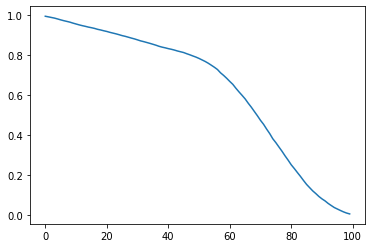

In [99]:
import matplotlib.pyplot as plt
plt.plot(np.average(sample_preds, axis=0))

- average distribution of 100 test users
- all 139230 items

In [100]:
preds = NCF.get_raw_predictions('NeuMF', train_set, test_set.iloc[:100])

100% |########################################################################|


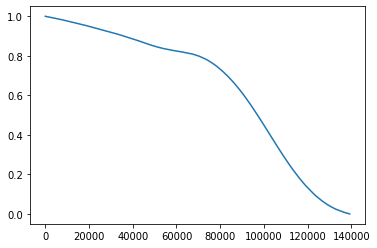

In [101]:
plt.plot(np.average(preds, axis=0))

In [102]:
len(set(preds[0]))

138660

In [121]:
uniques = []
for user_preds in preds:
    uniques.append(len(set(user_preds)))

In [122]:
preds[np.argmin(uniques)][:50]

array([1.        , 0.9999999 , 0.99999964, 0.9999995 , 0.9999995 ,
       0.9999994 , 0.9999993 , 0.999997  , 0.9999963 , 0.99999547,
       0.99999535, 0.999995  , 0.9999933 , 0.9999927 , 0.9999914 ,
       0.9999906 , 0.99999034, 0.9999887 , 0.999987  , 0.99998355,
       0.99998355, 0.9999809 , 0.99997747, 0.9999771 , 0.9999763 ,
       0.99997425, 0.99997246, 0.9999714 , 0.9999702 , 0.9999685 ,
       0.99996746, 0.9999665 , 0.99996614, 0.9999641 , 0.99995995,
       0.9999578 , 0.9999573 , 0.99995494, 0.9999547 , 0.9999546 ,
       0.99995005, 0.99994826, 0.9999478 , 0.99994695, 0.9999454 ,
       0.99994504, 0.9999442 , 0.9999424 , 0.9999423 , 0.99994206],
      dtype=float32)

In [103]:
total_items

139230

# Results 4 samples

In [77]:
sample_metrics_100

,rank_at,hitcounts,recall,precision,ndcg
0,1,653,0.16325,0.163250,0.163250
1,5,712,0.17800,0.035600,0.170003
2,10,807,0.20175,0.020175,0.177539
3,15,895,0.22375,0.014917,0.183291
4,20,944,0.23600,0.011800,0.186177


In [79]:
metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,0,0.0,0.0,0.0
1,5,0,0.0,0.0,0.0
2,10,0,0.0,0.0,0.0
3,15,0,0.0,0.0,0.0
4,20,0,0.0,0.0,0.0


In [ ]:
%%time
from Evaluation import get_metrics
test_set = test_set.iloc[:300]
sample_sizes = [500, 1000, 10000]
metrics = []
for sample_size in sample_sizes:
    ranked_sample_df = NCF.sample_prediction('NeuMF', train_set, test_set, sample_len=sample_size)
    metric = get_metrics(ranked_sample_df)
    metrics.append(metric)
#     get_metrics(ranked_sample_df).to_pickle(f'../results/NCF/NCF_metrics_{sample_size}_sample_am_40k')

In [ ]:
get_metrics(ranked_df_full, steps, rank_at).to_pickle('../results/NCF/NCF_metrics_ml_1m')
get_metrics(ranked_df, steps, rank_at).to_pickle('../results/NCF/NCF_metrics_100_sample_ml_1m')

## See predictions

In [149]:
test_set_og = test_set

In [162]:
test_set = test_set.iloc[:500]
sample_len = 15000
rank_at = 20

In [164]:
model, _ = NCF.get_model('NeuMF')

In [158]:
user_items = train_set.groupby('user_id')['item_id'].apply(list)
test_user_items = test_set.groupby('user_id')['item_id'].apply(list)
train_items = train_set.item_id.unique()

In [165]:
preds_ranked = []
true_items = []
pbar = progressbar.ProgressBar()
for u in pbar(test_user_items.index):
    true_item = test_user_items[u]
    pos_items = user_items[u]
    neg_items = set(train_items) - set(pos_items)
    neg_sample = np.random.choice(list(neg_items), sample_len-1)
    total_sample = np.append(true_item, neg_sample)
    user_array = np.full(len(total_sample), u, dtype='int32')

    preds = np.hstack(model.predict([user_array, total_sample], batch_size=sample_len, verbose=0))
    print(np.sort(preds)[-40:][::-1])
#     best = total_sample[np.argsort(preds)][-rank_at:][::-1]
    ids = np.argpartition(preds, -rank_at)[-rank_at:]
    best_ids = np.argsort(preds[ids])[::-1]
    best = total_sample[ids[best_ids]]

    preds_ranked.append(best)
    true_items.append(true_item)

ranked_df = pd.DataFrame(list(zip(test_user_items.index, preds_ranked, true_items)),
                         columns=['users', 'pred_items_ranked', 'true_id'])

[0.9956434  0.9951572  0.9950917  0.9948907  0.9945088  0.9931384
 0.99202067 0.9907787  0.99066895 0.99065    0.9899809  0.98996663
 0.9896769  0.9896606  0.9890085  0.9888465  0.9886746  0.98814744
 0.9879204  0.9878512  0.98780173 0.9875709  0.9874286  0.98719263
 0.98719263 0.98719263 0.9867951  0.98659885 0.98658854 0.9863073
 0.9852386  0.9852367  0.98486245 0.9846811  0.98447    0.98407817
 0.98329943 0.9831819  0.98317784 0.9830608 ]
[0.9999559  0.99988985 0.9997912  0.999777   0.99977297 0.9997607
 0.9997162  0.9997142  0.9996611  0.9996025  0.99956626 0.9995615
 0.9995609  0.9995577  0.99955267 0.99946755 0.9994628  0.9994506
 0.9994186  0.9993462  0.9993418  0.99931574 0.9992532  0.9992531
 0.99914896 0.99914837 0.99911696 0.9991084  0.9990613  0.99905926
 0.9990539  0.99904746 0.9990023  0.9989981  0.99889165 0.99888676
 0.99885464 0.9988115  0.99880934 0.99877614]
[0.9983834  0.99652475 0.9947048  0.9945446  0.9944563  0.9937543
 0.99374205 0.9931384  0.9925915  0.99256647

[0.9999999  0.9999999  0.9999995  0.9999994  0.9999994  0.9999993
 0.99999917 0.99999905 0.99999905 0.9999988  0.9999987  0.9999987
 0.9999987  0.9999982  0.9999976  0.9999976  0.9999975  0.9999975
 0.99999714 0.99999714 0.9999968  0.99999666 0.99999654 0.9999964
 0.9999964  0.99999607 0.99999595 0.99999595 0.99999475 0.9999944
 0.9999944  0.99999404 0.99999356 0.9999931  0.99999285 0.9999927
 0.9999926  0.9999925  0.99999225 0.99999166]
[0.99672    0.995983   0.9943077  0.99405175 0.9931384  0.9917026
 0.99097365 0.990842   0.9908202  0.99055123 0.9904508  0.9899603
 0.98991394 0.98982847 0.9896102  0.989027   0.989022   0.98894393
 0.9889259  0.9888304  0.9888209  0.9886141  0.9885727  0.9885634
 0.98839754 0.9880889  0.98717135 0.98688275 0.9868197  0.98675644
 0.98659885 0.98658854 0.9864253  0.9863122  0.98617226 0.9860771
 0.9858978  0.98578787 0.9856872  0.98565316]
[0.9996057  0.999146   0.9990631  0.99828124 0.99825734 0.9981996
 0.99815315 0.99800724 0.99780625 0.9976367  0.9

[0.99998796 0.9999869  0.9999819  0.99997866 0.99997735 0.9999739
 0.9999733  0.99995005 0.99994206 0.99993956 0.99993515 0.99992895
 0.9999267  0.99992466 0.9999229  0.99991965 0.99991643 0.9999163
 0.99991214 0.999908   0.999902   0.999897   0.9998963  0.9998956
 0.9998729  0.99987245 0.99986315 0.999861   0.999861   0.9998548
 0.9998468  0.99984586 0.99984086 0.99982834 0.9998216  0.9998209
 0.99981874 0.9998186  0.9998166  0.99981564]
[0.9998323  0.99975795 0.99960166 0.99958247 0.9994331  0.9993524
 0.999313   0.9992865  0.9992137  0.9991763  0.99885833 0.99880755
 0.9987532  0.99874866 0.99872977 0.9987231  0.9986487  0.9985782
 0.99849534 0.99847895 0.9984451  0.99839056 0.9983752  0.9983752
 0.9982851  0.9982779  0.9982674  0.99826294 0.9982236  0.99799335
 0.99795985 0.99790394 0.997886   0.99785954 0.9977076  0.99765116
 0.9976426  0.9976036  0.99751043 0.9975073 ]
[0.9995478  0.99912494 0.9990748  0.9981943  0.99697196 0.99648935
 0.995983   0.9954347  0.9949544  0.9949013  

[0.9986966  0.9981042  0.9918876  0.99168855 0.9915605  0.99139446
 0.9912845  0.9908886  0.9907066  0.9905991  0.9905991  0.98984945
 0.9887811  0.9882684  0.98817563 0.9878578  0.98766035 0.98753124
 0.98738396 0.98719263 0.9870667  0.98680127 0.98658854 0.98654944
 0.986542   0.98639756 0.9863073  0.986252   0.98595494 0.9859313
 0.9858978  0.98555213 0.9854719  0.9853613  0.98514634 0.9848578
 0.9847668  0.9846772  0.9846015  0.9845143 ]
[0.99826753 0.9965669  0.99513406 0.9948148  0.99449337 0.9943077
 0.99210465 0.99168855 0.99109143 0.9907066  0.9897837  0.98946524
 0.9894049  0.9894049  0.9892167  0.9891867  0.989027   0.9887811
 0.9886746  0.9886072  0.9885211  0.98798174 0.9875014  0.9874286
 0.9870745  0.9865601  0.98654455 0.98641324 0.98639756 0.9863073
 0.9862017  0.98617226 0.9859577  0.985897   0.98582447 0.98581684
 0.9856371  0.9855114  0.9851992  0.9848599 ]
[0.9998429  0.999819   0.9996731  0.9996642  0.9995703  0.99953437
 0.9995314  0.99948454 0.9994205  0.9994055

[0.99894553 0.99683505 0.9960353  0.9959416  0.9954347  0.994118
 0.9938883  0.99374205 0.99335456 0.9925915  0.9925506  0.9922983
 0.99152815 0.99139446 0.99137783 0.9908886  0.9908749  0.99066895
 0.9904869  0.9904508  0.99032485 0.9899014  0.9898263  0.98889285
 0.9888304  0.9887967  0.9886746  0.9886141  0.98852265 0.9882684
 0.9881941  0.9879689  0.9879689  0.98790467 0.9874893  0.9874538
 0.9874171  0.9866022  0.98654455 0.98641324]
[0.99826753 0.9981943  0.99524176 0.9948148  0.993956   0.99333066
 0.99319685 0.9931384  0.9925915  0.9922983  0.9918876  0.9917026
 0.9916421  0.99148667 0.99109143 0.99101454 0.9905991  0.9904869
 0.990408   0.9903957  0.99012053 0.989967   0.98991394 0.9898263
 0.9891867  0.98912233 0.9887811  0.98873025 0.98855805 0.98839754
 0.9877752  0.98770756 0.9875546  0.9873986  0.9872994  0.98705137
 0.98702955 0.986542   0.9862363  0.9862363 ]
[0.999907   0.99954826 0.99953556 0.9994443  0.9993406  0.99924767
 0.99920374 0.99911624 0.99907553 0.9989513  

[0.99912494 0.9977139  0.9950917  0.9943619  0.9922983  0.99139446
 0.99109143 0.9910522  0.99101454 0.99097365 0.9908202  0.9907787
 0.99032485 0.990316   0.9894649  0.9889698  0.9889259  0.9881621
 0.9879578  0.98753124 0.9874893  0.9874628  0.9872171  0.9870667
 0.98654944 0.9858978  0.98581684 0.9855849  0.98536366 0.9849037
 0.9849037  0.98445547 0.984443   0.9838277  0.9838277  0.98359513
 0.9835849  0.9835398  0.9833581  0.98323905]
[0.99983144 0.9995671  0.9995478  0.99952006 0.9994469  0.9994035
 0.9993993  0.9993806  0.99937016 0.99932957 0.999302   0.99927574
 0.9992473  0.9992453  0.9992099  0.9991417  0.9990922  0.99908376
 0.99900466 0.99898297 0.9989496  0.99892527 0.9987764  0.99874854
 0.99872655 0.9987011  0.9986889  0.99860567 0.9985902  0.9984035
 0.9983438  0.9982942  0.99828905 0.9981364  0.99809426 0.9980136
 0.9979905  0.9979772  0.997965   0.997962  ]
[0.99999964 0.99999464 0.99999344 0.9999931  0.99999297 0.999992
 0.9999888  0.99998546 0.99997675 0.99996996 0

[0.99912494 0.99672    0.9963213  0.9960353  0.9943347  0.9933935
 0.9933206  0.9933206  0.99319685 0.9925506  0.9915605  0.9903042
 0.9899384  0.9896606  0.9896102  0.98839754 0.98801863 0.9879689
 0.98764825 0.98764825 0.9875014  0.9875014  0.9874893  0.9872994
 0.98719263 0.9870667  0.9870488  0.98639756 0.9863897  0.98610604
 0.9856371  0.98524255 0.9846811  0.98445547 0.98445547 0.9844072
 0.9843178  0.9842609  0.98411894 0.98404586]
[0.9999807  0.99996805 0.9999192  0.9999186  0.9999186  0.9999137
 0.99990475 0.9998983  0.9998956  0.9998902  0.9998846  0.99986625
 0.99985623 0.9998555  0.99985266 0.9998274  0.99980575 0.9998024
 0.99979967 0.9997886  0.9997683  0.99976736 0.99976283 0.9997588
 0.9997501  0.9997056  0.99970466 0.99968207 0.9996741  0.9996666
 0.99966574 0.99965775 0.99964404 0.99964404 0.99964404 0.99963605
 0.99962544 0.9996253  0.9996214  0.99961394]
[0.99995005 0.99993896 0.9999281  0.99991286 0.99989104 0.9998815
 0.9998627  0.9998621  0.9998529  0.99983644 0.

[0.9998338  0.9998338  0.99979275 0.99974865 0.9997279  0.99961996
 0.99961996 0.9995497  0.9995345  0.99921906 0.9991978  0.9991934
 0.9991247  0.9989785  0.9989619  0.9988242  0.99880934 0.99880934
 0.99876887 0.9987569  0.9987437  0.9987437  0.99871254 0.99868184
 0.99843043 0.9982975  0.9981987  0.99819595 0.99806553 0.9980603
 0.9979315  0.9979067  0.9978163  0.9977701  0.99776244 0.99775463
 0.99770206 0.9976566  0.99755055 0.9974886 ]
[0.99998116 0.99966896 0.99963737 0.9995491  0.999401   0.99939716
 0.9992617  0.9992617  0.99917287 0.9991455  0.9991209  0.99882835
 0.99878496 0.99861956 0.99861836 0.99861836 0.99861836 0.99860173
 0.9985966  0.9985593  0.99855703 0.9984621  0.9984604  0.9984497
 0.9983248  0.99830097 0.9982072  0.99820495 0.99819916 0.9981505
 0.9980166  0.99798703 0.9979717  0.99786794 0.997757   0.99767
 0.99762374 0.9976156  0.9976023  0.9975732 ]
[0.9993938  0.99912494 0.99912494 0.9983834  0.995983   0.9946173
 0.9946173  0.9945446  0.9936441  0.99351114 

[0.9995478  0.9990748  0.9986966  0.9981943  0.9977139  0.9939348
 0.99374205 0.99335456 0.99335456 0.9925915  0.99202067 0.99148667
 0.99128515 0.99103504 0.9904508  0.99032485 0.99014294 0.989967
 0.98996663 0.98933357 0.9889698  0.98894393 0.9886746  0.9886746
 0.9886746  0.98855805 0.9880889  0.98756033 0.98756033 0.9874171
 0.9874171  0.9874171  0.9874171  0.9874121  0.98680127 0.986636
 0.9865805  0.9864482  0.9864442  0.98639756]
[0.99894553 0.99648935 0.99648935 0.99577004 0.99577004 0.9957373
 0.9946173  0.993956   0.99168855 0.99139446 0.9908749  0.990842
 0.9907066  0.99055123 0.989967   0.98933357 0.98876256 0.98873425
 0.9885727  0.98775893 0.9874286  0.9872994  0.98696774 0.98693466
 0.9864123  0.98637146 0.9862228  0.98608273 0.98555213 0.98528427
 0.9852386  0.9852129  0.9850487  0.98492116 0.98472834 0.98447
 0.9838574  0.98373806 0.98373806 0.98372275]
[0.9993938  0.9981943  0.99722135 0.9966877  0.9945446  0.9943619
 0.9931384  0.99202067 0.99168855 0.99128515 0.9910

[0.9998142  0.9997892  0.99975437 0.99971837 0.99970573 0.99963117
 0.99962866 0.99958557 0.99949217 0.99949217 0.9994155  0.9994141
 0.99938774 0.99938774 0.99937207 0.999366   0.9993537  0.9993267
 0.999326   0.99926656 0.9992644  0.9992487  0.9992459  0.9991511
 0.9991277  0.99909806 0.9990823  0.99900585 0.99900585 0.9989802
 0.9988949  0.9988949  0.99882287 0.99882287 0.99880934 0.99875784
 0.9987294  0.9986934  0.9986891  0.99868685]
[0.99983144 0.9995478  0.99894553 0.9981943  0.99672    0.9949544
 0.99438757 0.9943077  0.99351114 0.99175394 0.99055123 0.990408
 0.990319   0.9899014  0.98982847 0.98982847 0.9896769  0.9891426
 0.98912233 0.9887811  0.9886746  0.9885727  0.9882684  0.9874628
 0.9873986  0.98725325 0.9870667  0.98688275 0.9867951  0.98675644
 0.9864253  0.9864123  0.9863897  0.98634815 0.9862363  0.98616564
 0.9860771  0.98595494 0.98574346 0.9855114 ]
[0.9990748  0.9981042  0.9966877  0.9965669  0.9949544  0.9944857
 0.99405175 0.9936441  0.99168855 0.9916421  0.

[0.9999474  0.99992204 0.9998375  0.999816   0.9998023  0.9997744
 0.9996985  0.99963784 0.9996197  0.9995449  0.9995291  0.9995221
 0.99951684 0.9995147  0.9995147  0.9995147  0.99946326 0.9994462
 0.99943393 0.9994235  0.9994215  0.99941826 0.99940157 0.9993938
 0.99937916 0.99936837 0.99927646 0.9992712  0.99923813 0.9992353
 0.9992261  0.99922574 0.99922144 0.99922025 0.9992101  0.9992023
 0.9991518  0.9991179  0.99911326 0.99909675]
[0.9990748  0.9986966  0.9983834  0.9977139  0.99652475 0.9959416
 0.9945446  0.994118   0.9939348  0.9937543  0.9925915  0.9922983
 0.9912845  0.99103504 0.9908749  0.9904869  0.9903956  0.9903042
 0.98982847 0.9891533  0.9891533  0.9887967  0.98873025 0.98871875
 0.98845345 0.98832977 0.9882047  0.9882032  0.9878512  0.987495
 0.9874893  0.9874121  0.98738396 0.9872717  0.9870684  0.9867951
 0.98659885 0.9860771  0.9854494  0.9854494 ]
[0.99860567 0.99826753 0.9980496  0.9980496  0.99672    0.9954347
 0.9954347  0.9951572  0.9949544  0.99168855 0.991

[0.99988806 0.99987984 0.9998691  0.99985945 0.99985135 0.9998388
 0.9998388  0.9998305  0.99976057 0.99973875 0.99972504 0.9997112
 0.99970764 0.9996456  0.99963903 0.999617   0.9996126  0.9996111
 0.99953973 0.9995358  0.99950826 0.9995073  0.9995043  0.9994912
 0.9994777  0.9994747  0.9994672  0.9994295  0.9993806  0.9993806
 0.9993648  0.9993259  0.9993056  0.9992902  0.9992717  0.9992717
 0.9992557  0.9992229  0.99920565 0.99918514]
[0.99991894 0.9998492  0.9998319  0.9998141  0.99977297 0.9997398
 0.9997334  0.999705   0.9996612  0.99963963 0.9996357  0.999603
 0.9995035  0.99950147 0.99950147 0.9994875  0.9994635  0.99943835
 0.9994198  0.999383   0.99937135 0.99937135 0.99932325 0.9992933
 0.9992933  0.9992841  0.99927837 0.99924916 0.9992054  0.9991684
 0.9991604  0.9991534  0.99906284 0.9990607  0.9990515  0.9990337
 0.99898154 0.99893945 0.99892896 0.99892896]
[0.99998295 0.9999504  0.999795   0.99969566 0.9996625  0.99962056
 0.99960774 0.9995741  0.9995704  0.99952126 0.99

[0.9998716  0.9998653  0.9998399  0.9998098  0.9997348  0.99971515
 0.9996408  0.99962234 0.999587   0.99957687 0.9995573  0.9995272
 0.9994331  0.99940526 0.9993167  0.99930155 0.99926966 0.99925405
 0.9992499  0.99921954 0.9992186  0.9991775  0.9990753  0.9990621
 0.9990514  0.99895966 0.99895966 0.99892944 0.9989197  0.99885523
 0.9988231  0.99879164 0.99879164 0.9987255  0.99865085 0.9986338
 0.99858934 0.9985481  0.9985258  0.99845827]
[0.99963546 0.9986966  0.9986966  0.99672    0.9950917  0.9950917
 0.9945446  0.9933206  0.99275523 0.99210465 0.9918065  0.9914621
 0.99109143 0.9908202  0.9907918  0.9904869  0.99014294 0.99014294
 0.98962384 0.9891533  0.9890085  0.9888465  0.9887967  0.9886141
 0.98836577 0.98761475 0.9875709  0.98756033 0.9874121  0.9873986
 0.98738396 0.9860508  0.98595494 0.9859374  0.9858978  0.9852386
 0.9852129  0.9851992  0.9850487  0.98496336]
[0.99999297 0.99985385 0.9998387  0.9998373  0.9998373  0.9997682
 0.99975497 0.99966764 0.9996674  0.99960965 0

[0.9993938  0.9966877  0.99652475 0.9951572  0.9944563  0.9938883
 0.9918876  0.9916421  0.9916421  0.99137783 0.9908875  0.99032485
 0.989967   0.9899014  0.98984945 0.9887811  0.9882047  0.9879689
 0.98756033 0.9874085  0.98738396 0.986636   0.9864442  0.98638237
 0.9862228  0.985897   0.9858543  0.9857964  0.9856872  0.9853613
 0.98535955 0.9850487  0.985038   0.98496336 0.98467493 0.98447925
 0.98445547 0.9844434  0.984443   0.98417795]
[0.99894553 0.9987544  0.9972475  0.99683505 0.99648935 0.9947048
 0.993956   0.99275523 0.9918876  0.9913152  0.9907918  0.990575
 0.990408   0.99012053 0.9896769  0.98962384 0.989022   0.98873025
 0.9880904  0.98792654 0.98761475 0.9872994  0.9872171  0.98713094
 0.9868175  0.98637146 0.9860771  0.9859374  0.9854952  0.9853419
 0.9853419  0.9852401  0.9850487  0.98502445 0.98496336 0.98493284
 0.98486245 0.98445547 0.9843035  0.9840837 ]
[0.9956434  0.9945446  0.9936441  0.99333066 0.99333066 0.9918876
 0.9913009  0.9912845  0.99097997 0.99097365 

[0.9995478  0.9983834  0.9967437  0.99672    0.9949544  0.9945088
 0.9944563  0.9937543  0.9936441  0.99351114 0.99202067 0.9916421
 0.99152815 0.99124676 0.99101454 0.9907918  0.9907918  0.9899384
 0.98989826 0.9897837  0.98933357 0.9891867  0.9891533  0.9887811
 0.9886746  0.9886072  0.98836577 0.98801863 0.9879578  0.98790467
 0.9875546  0.98754245 0.98753124 0.98746324 0.9874628  0.9874538
 0.9874286  0.98727036 0.98725325 0.98705137]
[0.9999838  0.9999789  0.99985385 0.999843   0.9996717  0.9995696
 0.9995659  0.99947053 0.9994374  0.99941707 0.999388   0.9993606
 0.99922824 0.99922824 0.99922824 0.9991467  0.9991279  0.99904174
 0.9989858  0.99888307 0.99888307 0.99885154 0.9988446  0.9988294
 0.99865156 0.99861085 0.99860674 0.9985844  0.99852705 0.998345
 0.99829787 0.9982481  0.9981071  0.9980071  0.9979316  0.9979298
 0.99790525 0.99790525 0.9978314  0.99779725]
[0.9999765  0.9999348  0.9999285  0.9998841  0.9998535  0.9998006
 0.9997907  0.99971133 0.999676   0.99967134 0.99

[0.9977139  0.99683505 0.99652475 0.9933935  0.99202067 0.9917464
 0.9914621  0.99137783 0.9910386  0.99097365 0.9908202  0.989967
 0.9897837  0.9894449  0.98859686 0.98853683 0.98839754 0.98817563
 0.9880904  0.98775893 0.98770756 0.98767006 0.98746324 0.98713094
 0.9868197  0.98608273 0.9856725  0.9856371  0.9854494  0.9851992
 0.98496336 0.9847668  0.9847668  0.98417795 0.98402333 0.9838574
 0.9838217  0.98372126 0.98368907 0.98359513]
[0.99956614 0.9993938  0.99912494 0.99912494 0.9966877  0.9965669
 0.99652475 0.9957373  0.99524176 0.994118   0.99374205 0.9915605
 0.9915605  0.9908202  0.9908202  0.9899603  0.9899014  0.9894449
 0.98890334 0.9888209  0.98853683 0.9881941  0.98761475 0.98719263
 0.98702955 0.986542   0.98641324 0.9862017  0.9862017  0.985897
 0.98582447 0.9856872  0.98563266 0.98535955 0.9851687  0.9851231
 0.9850935  0.9849037  0.98467493 0.9846015 ]
[0.9993938  0.9967437  0.9950917  0.9949544  0.9949013  0.9944857
 0.9938883  0.9938883  0.9916421  0.99101454 0.99

[0.99999034 0.9999862  0.99992037 0.99981505 0.99978966 0.999747
 0.99971706 0.99966574 0.9996536  0.9995534  0.99947244 0.99947244
 0.99945325 0.9993292  0.99931216 0.9992588  0.9992206  0.9991297
 0.99912673 0.99911886 0.99908984 0.9990835  0.99901366 0.9990075
 0.9989575  0.99894494 0.9988381  0.99880826 0.99880826 0.9986217
 0.9986022  0.99856794 0.9985636  0.99847966 0.9984787  0.9984396
 0.9984301  0.99841046 0.9983876  0.9983694 ]
[0.9999969  0.9997576  0.9996679  0.999617   0.999617   0.9996132
 0.9995223  0.999509   0.9994199  0.99936694 0.9993637  0.99930966
 0.9992926  0.99920386 0.9991543  0.99903655 0.9989649  0.9989237
 0.9989164  0.9989023  0.99888784 0.9988512  0.9988248  0.9988136
 0.9988072  0.9987016  0.99869496 0.9986565  0.9985751  0.9985671
 0.9984837  0.9983726  0.998251   0.99819225 0.9981748  0.9980989
 0.9980883  0.99807644 0.9980484  0.99797636]
[0.99983144 0.9981943  0.99722135 0.9945446  0.9916421  0.9910944
 0.990575   0.99055123 0.99032485 0.9899384  0.98

KeyboardInterrupt: 

In [92]:
get_metrics(ranked_df, 5, rank_at, stats=False)

,rank_at,hitcounts,recall,precision,ndcg
0,1,0,0.000,0.0000,0.000000
1,5,5,0.010,0.0020,0.003956
2,10,24,0.048,0.0048,0.015909
3,15,51,0.102,0.0068,0.030284
4,20,68,0.136,0.0068,0.038184


---
# Appendix

### Best GMF Params (ML_1M)

In [ ]:
GMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 128,
    'nolf': 8,
    'regs': [0.00001,0.00001],
    'epochs': 20,
    'sample_size': len(train_set),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'ckpt_dir': f'../NeuMF_storage/GMF_ckpts_{run_num}/ckpts',
    'optimizer':'Adam'
}

### Multiprocessing for multiple samples creatings 

In [ ]:
# from progressbar import progressbar
# def create_samples(params, data, name=''):
#         print(f'Creating Samples for {name}')
# #         _, params = self.get_model(name)
#         all_user_inputs, all_item_inputs, all_labels = [], [], []
#         user_items = data.groupby('user_id')['item_id'].apply(list)
#         train_users = data.user_id.unique()
#         train_items = data.item_id.unique()

#         pbar = progressbar.ProgressBar()
#         for n in pbar(range(params['epochs'])):
#             user_inputs, item_inputs, labels = [], [], []
#             for s in range(int(params['sample_size'])):
#                 # Add positive item
#                 u = np.random.choice(train_users)
#                 u_items = user_items[u]
#                 i = np.random.choice(u_items)

#                 user_inputs.append(u)
#                 item_inputs.append(i)
#                 labels.append(1)

#                 # Add negative item
#                 for i in range(params['num_neg']):
#                     j = np.random.choice(train_items)
#                     while j in u_items:  # neg item j cannot be in the set of pos items of user u
#                         j = np.random.choice(train_items)

#                     user_inputs.append(u)
#                     item_inputs.append(j)
#                     labels.append(0)

#             all_user_inputs.append(user_inputs)
#             all_item_inputs.append(item_inputs)
#             all_labels.append(labels)

#         return [all_user_inputs, all_item_inputs, all_labels]

In [ ]:
# import multiprocessing as mp
# if __name__ == '__main__':
    
#     with mp.Pool(processes=2) as pool:
#         results = pool.starmap(create_samples, [(GMF_params, train_set, 'GMF'), (MLP_params, train_set, 'MLP')])
        

## MP sampler

In [ ]:
def subsampler(worker_id, epochs, user_items, train_users, train_items, params):
    print(f'worker {workes_id} started')
    all_user_inputs, all_item_inputs, all_labels = [], [], []
    for epoch in range(epochs): 
        user_inputs, item_inputs, labels = [], [], []
        for s in range(params['sample_size']):
            # Add positive item
            u = np.random.choice(train_users)
            u_items = user_items[u]
            i = np.random.choice(u_items)

            user_inputs.append(u)
            item_inputs.append(i)
            labels.append(1)

            # Add negative item
            for i in range(params['num_neg']):
                j = np.random.choice(train_items)
                while j in u_items:  # neg item j cannot be in the set of pos items of user u
                    j = np.random.choice(train_items)

                user_inputs.append(u)
                item_inputs.append(j)
                labels.append(0)
                
        all_user_inputs.append(user_inputs)
        all_item_inputs.append(item_inputs)
        all_labels.append(labels)
        
    return {'u':all_user_inputs, 'i':all_item_inputs, 'l':all_labels}

In [ ]:
%%time
import multiprocessing as mp
from progressbar import progressbar
if __name__ == '__main__':
    processors = mp.cpu_count()
    params = NCF.GMF_params
#     params = NCF.MLP_params
#     params = NCF.NeuMF_params
    data = train_set

    all_user_inputs, all_item_inputs, all_labels = [], [], []
    user_items = data.groupby('user_id')['item_id'].apply(list)
    train_users = data.user_id.unique()
    train_items = data.item_id.unique()
    
    epoch_splits = np.array_split(np.array(range(params['epochs'])), processors)
    args = []
    for worker_id, epoch_split in enumerate(epoch_splits):
        args.append((worker_id, len(epoch_split), user_items, train_users, train_items, params))
        
    with mp.Pool(processes=processors) as pool:
        results = pool.starmap(subsampler, args)
    
    all_user_inputs, all_item_inputs, all_labels = [], [], []
    samples = [[], [], []]
    for res_epochs in results:
        all_user_inputs.extend(res_epochs['u'])
        all_item_inputs.extend(res_epochs['i'])
        all_labels.extend(res_epochs['l'])
    
    GMF_samples_mp = [all_user_inputs, all_item_inputs, all_labels]
#     MLP_samples_mp = [all_user_inputs, all_item_inputs, all_labels]
#     NeuMF_samples_mp = [all_user_inputs, all_item_inputs, all_labels]


In [ ]:
import multiprocessing as mp
from Evaluation import get_metrics
def train_model(name='', train_set=[], val_set=[], verbose=1, store_path=''):
    model, params = NCF.get_model(name)

    ckpts_prefix = os.path.join(params['ckpt_dir'], "ckpt")
    ckpts_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpts_prefix,    
                                                     monitor='loss',    
                                                     mode='min',    
                                                     save_best_only=True,
                                                     save_weights_only=True)

    if len(train_set) == 0:
        raise Exception('No samples available, create samples first using: create_samples')
        
    val_metrics = fit(model, params, train_set, val_set, [ckpts_callback], verbose)

    if len(store_path) > 0:
        model.save_weights(store_path)
        
    return val_metrics


def fit(model, params, train_set, val_set, callbacks, verbose):
    print(f'\nFitting {model._name} with parameters:')
    print(pd.DataFrame.from_dict(params, orient='index'))
    user_items = train_set.groupby('user_id')['item_id'].apply(list)
    train_users = train_set.user_id.unique()
    train_items = train_set.item_id.unique()
    num_processes = mp.cpu_count()
    val_metrics = []
    for epoch in range(params['epochs']):
        print(f'Epoch: {epoch}')
        user_inputs, item_inputs, labels = create_sample(user_items, train_users, train_items, params, num_processes)
        hist = model.fit([np.array(user_inputs), np.array(item_inputs)], 
                  np.array(labels), 
                  batch_size=params['batch_size'], 
                  verbose=verbose, 
                  epochs=1, 
                  shuffle=True,
                  callbacks=callbacks)
        
        ranked_df = sample_prediction(model, train_set, val_set)
        val_metrics.append(get_metrics(ranked_df, 5, 20, stats=False))
        print(val_metrics[-1:])

        NCF.history[model._name]['loss'].append(round(hist.history['loss'][0],5))
    return val_metrics
        
        
def create_sample(user_items, train_users, train_items, params, num_processes):
    samples_sizes_split = np.array_split(np.array(range(params['sample_size'])),8)
    args = []
    for samples_size in samples_sizes_split:
        args.append((user_items, train_users, train_items, len(samples_size), params['num_neg']))
    with mp.Pool(processes=num_processes) as pool:
        results = pool.starmap(create_sample_worker, args)

    user_inputs, item_inputs, labels = [], [], []
    for res_epochs in results: 
        user_inputs.extend(res_epochs['u'])
        item_inputs.extend(res_epochs['i'])
        labels.extend(res_epochs['l'])

    return user_inputs, item_inputs, labels


def create_sample_worker(user_items, train_users, train_items, sample_size, num_neg):
    user_inputs, item_inputs, labels = [], [], []
#     print('worker started')
    for s in range(sample_size):
        # Add positive item
        u = np.random.choice(train_users)
        u_items = user_items[u]
        i = np.random.choice(u_items)

        user_inputs.append(u)
        item_inputs.append(i)
        labels.append(1)

        # Add negative item
        for i in range(num_neg):
            j = np.random.choice(train_items)
            while j in u_items:  # neg item j cannot be in the set of pos items of user u
                j = np.random.choice(train_items)

            user_inputs.append(u)
            item_inputs.append(j)
            labels.append(0)

    return {'u':user_inputs, 'i':item_inputs, 'l':labels}